#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> Imputing Into None

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> functions

In [1]:
def optimize_dtypes( data, ft ):
    for dtype in [ 'int32', 'int64', 'datetime64', 'float32', 'float64' ]:
        try:
            data[ft] = data[ft].astype(dtype)
            break
        except (ValueError, TypeError, AttributeError):
            continue
    return data[ft]

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Importing Libraries

In [2]:
import numpy  as np
import polars as pl
import pandas as pd
pd.set_option('display.max_columns',None) 
pd.set_option('display.max_rows'   ,200 )

import matplotlib.pyplot as plt
import seaborn           as sns
sns.set(style="ticks", color_codes=True)

import time, pickle
t_init = time.time()

import warnings 
warnings.filterwarnings('ignore') 

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Template DataFrame

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Importing DataSet

In [3]:
## input
# 📥 Load raw data file
data_file    = 'housing_new.csv'
data_sheet   = 'housing_new'
Project_Name = 'housing'

## auto
# ⏱️ Start timing
t1 = time.time()

# 💾 Save/load project name using pickle
pickle.dump( Project_Name, open('Project_Name','wb'))  # save
Project_Name = pickle.load(open('Project_Name','rb'))  # load

# 🧹 Define garbage/null tokens
Garbage_List = ['nan','NaN','None','?','!','#','*','/'] + [''] + ['.'] + [',']

# ⚡ Try Polars for fast CSV read; fallback to Pandas
try:
    data = pl.read_csv(source=data_file, null_values=Garbage_List).to_pandas()
    print("data is read by polars")
except:
    data = pd.read_csv(data_file, header=0)
    data.index = range(data.shape[0])
    print("data is read by pandas")

# 🧠 Optimize column data types
for ft in data.columns:
    try:
        float_percent = 100 * data.loc[ data[ft] % 1 > 0, [ft] ].shape[0] / data.shape[0]
        if float_percent <= 1:
            data[ft] = round(data[ft])
            data[ft] = optimize_dtypes( data, ft )
    except:
        ;

# 🏷️ Renaming Columns
data.columns = (
    data.columns
        .str.strip()
        .str.lower()
        .str.replace(r'%+', '_', regex=True)
        .str.replace(r'[^\w\s]', '', regex=True)
        .str.replace(' ', '_')
)

# 🔢 Adjusting Index
data.index = data.index + 2
data.index.name = "row"

# ⬜ removing Blank Spaces
data = data.apply( 
    lambda col: col.str.replace(r'\s+', ' ', regex=True).str.strip() 
    if col.dtype == "object" else col )

# ⏱️ End timing and report
t2 = time.time()
print(int(round((t2-t1), 0)), 'seconds')

# 📊 Show data shape and last 5 rows
print(f'there are {data.shape[0]} rows and {data.shape[1]} columns.')
data.tail(5)

data is read by polars
1 seconds
there are 20645 rows and 23 columns.


,row,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bin_num,bin_cat,ord_num,ord_cat,datetime,year,age,elapsed_days,month,hour,nominal_num,nominal_cat
row,,,,,,,,,,,,,,,,,,,,,,,
20642,20642,-121.09,39.48,25.0,1665,374.0,845.0,330.0,1.5603,78100.0,INLAND,0.0,No,5.0,Very High,2024-11-15 16:00:00,2023.0,37.0,189.0,1.0,4.0,3.0,Green
20643,20643,-121.21,39.49,18.0,697,150.0,356.0,114.0,2.5568,77100.0,INLAND,0.0,No,2.0,Low,2016-09-01 21:00:00,2022.0,18.0,196.0,3.0,20.0,0.0,Violet
20644,20644,-121.22,39.43,17.0,2254,485.0,1007.0,433.0,1.7000,92300.0,INLAND,0.0,No,2.0,Low,2019-01-13 20:00:00,2003.0,14.0,194.0,4.0,18.0,2.0,Blue
20645,20645,-121.32,39.43,18.0,1860,409.0,741.0,349.0,1.8672,84700.0,INLAND,NaN,None,NaN,None,None,2007.0,39.0,82.0,5.0,3.0,NaN,None
20646,20646,-121.24,39.37,16.0,2785,616.0,1387.0,530.0,2.3886,89400.0,INLAND,NaN,None,NaN,None,None,2004.0,17.0,200.0,11.0,7.0,NaN,None


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Synthetic Data

In [4]:
def add_synthetic_features(df: pd.DataFrame, missing_rate: float = 0.01) -> pd.DataFrame:
    """
    Add synthetic features with both numeric and wordy categorical variants:
    - Binary: 0/1 and 'Yes'/'No'
    - Ordinal: 1–5 and 'Very Low'...'Very High'
    - Datetime: random dates + numeric year + categorical weekday names
    - Categorical: random labels like 'Red','Green','Blue'
    Each feature has ~missing_rate fraction of values set to NaN.
    """
    n = len(df)
    
    def introduce_missing(series, rate=missing_rate):
        mask = np.random.rand(n) < rate
        series = series.astype("object")  # allow NaN in both numeric/cat
        series[mask] = np.nan
        return series
    
    # Binary
    bin_num = np.random.randint(0, 2, n)
    df["bin_num"] = introduce_missing(pd.Series(bin_num))
    df["bin_cat"] = introduce_missing(pd.Series(np.where(bin_num == 1, "Yes", "No")))
    
    # Ordinal
    ord_num = np.random.randint(1, 6, n)
    ord_map = {1:"Very Low", 2:"Low", 3:"Medium", 4:"High", 5:"Very High"}
    df["ord_num"] = introduce_missing(pd.Series(ord_num))
    df["ord_cat"] = introduce_missing(pd.Series([ord_map[v] for v in ord_num]))
    
    
    # Datetime
    start, end   = pd.Timestamp("2015-01-01"), pd.Timestamp("2025-12-31")
    rand_seconds = np.random.randint(0, (end - start).total_seconds(), n)
    date_vals    = start + pd.to_timedelta(rand_seconds, unit="s")
    date_vals    = date_vals.floor("h") 
    
    df["dateTime"] = introduce_missing( pd.Series(date_vals) ) 
    
    df["dateTime"] = pd.to_datetime(df["dateTime"], errors="coerce")
    df["dateTime"] = df["dateTime"].dt.strftime("%Y-%m-%d %H:%M:%S")
    #df["dateTime"] = pd.to_datetime(df["dateTime"], errors="coerce")
    
    
    # Temporal Ind Dir 
    df['year']         = np.random.randint(2000,2025+1,size=data.shape[0])
    df['age' ]         = np.random.randint(  12,  45+1,size=data.shape[0])
    df['elapsed_days'] = np.random.randint(   0, 217+1,size=data.shape[0])
    
    df.loc[ [7, 8], ['year' ,'age','elapsed_days'] ] = np.nan

    
    # Temporal Ind Cyc
    df['month'] = np.random.randint(1,12+1,size=data.shape[0])
    df['hour' ] = np.random.randint(0,23+1,size=data.shape[0]) 
    
    df.loc[ [9,10], ['month','hour'] ] = np.nan
    
    
    # Categorical
    colors = np.random.choice(["Red","Green","Blue","Pink","Violet"], n)
    df["nominal_num"] = introduce_missing(pd.Series(pd.factorize(colors)[0]))
    df["nominal_cat"] = introduce_missing(pd.Series(colors))
    
    return df

df = pd.DataFrame(index=data.index)
df = add_synthetic_features( df, missing_rate=0.01 )
for ft in df.columns: df[ft] = optimize_dtypes( df, ft ) 
df.head(3)

,bin_num,bin_cat,ord_num,ord_cat,dateTime,year,age,elapsed_days,month,hour,nominal_num,nominal_cat
row,,,,,,,,,,,,
2,0.0,No,1.0,Very Low,2019-04-22 23:00:00,2021.0,16.0,208.0,11.0,14.0,1.0,Red
3,1.0,Yes,3.0,Medium,2017-09-28 13:00:00,2011.0,31.0,25.0,12.0,23.0,2.0,Green
4,0.0,No,1.0,Very Low,2020-03-07 17:00:00,2016.0,34.0,45.0,2.0,21.0,3.0,Pink


In [5]:
df.dtypes

bin_num         float32
bin_cat          object
ord_num         float32
ord_cat          object
dateTime         object
year            float32
age             float32
elapsed_days    float32
month           float32
hour            float32
nominal_num     float32
nominal_cat      object
dtype: object

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> data + synthetic features

In [6]:
#data = pd.concat([data,df],axis=1)
#data.to_csv('housing_new.csv')
data.head(3)

,row,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bin_num,bin_cat,ord_num,ord_cat,datetime,year,age,elapsed_days,month,hour,nominal_num,nominal_cat
row,,,,,,,,,,,,,,,,,,,,,,,
2,2,-122.23,37.88,41.0,880,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1.0,Yes,5.0,Very High,2025-12-17 22:00:00,2001.0,27.0,141.0,10.0,21.0,0.0,Violet
3,3,-122.22,37.86,21.0,7099,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1.0,Yes,4.0,High,2025-07-18 07:00:00,2020.0,35.0,5.0,3.0,18.0,2.0,Blue
4,4,-122.24,37.85,52.0,1467,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,1.0,Yes,1.0,Very Low,2022-08-24 21:00:00,2001.0,43.0,78.0,2.0,6.0,3.0,Green


In [7]:
data.dtypes

row                     int32
longitude             float64
latitude              float64
housing_median_age    float32
total_rooms             int32
total_bedrooms        float32
population            float32
households            float32
median_income         float64
median_house_value    float32
ocean_proximity        object
bin_num               float32
bin_cat                object
ord_num               float32
ord_cat                object
datetime               object
year                  float32
age                   float32
elapsed_days          float32
month                 float32
hour                  float32
nominal_num           float32
nominal_cat            object
dtype: object

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Object Features

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Correcting Object Features
 - Typical: 
    - misformated. eg: 1..5 1,5
      - Do here
    - aaa@bbb ------ aaa bbb  
      - Do not do it here
      - Do at Z_A1_Feature Engineering

In [8]:
# help 
Cs = [col for col in data.columns if data[col].dtype=='object']
data[Cs].head(3)

,ocean_proximity,bin_cat,ord_cat,datetime,nominal_cat
row,,,,,
2,NEAR BAY,Yes,Very High,2025-12-17 22:00:00,Violet
3,NEAR BAY,Yes,High,2025-07-18 07:00:00,Blue
4,NEAR BAY,Yes,Very Low,2022-08-24 21:00:00,Green


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Dropping Columns

In [9]:
# help
print( list(data.columns) )

['row', 'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity', 'bin_num', 'bin_cat', 'ord_num', 'ord_cat', 'datetime', 'year', 'age', 'elapsed_days', 'month', 'hour', 'nominal_num', 'nominal_cat']


In [10]:
# input
drop_list = ['row']
data = data.drop( drop_list, axis=1 )
print( list(data.columns) )

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity', 'bin_num', 'bin_cat', 'ord_num', 'ord_cat', 'datetime', 'year', 'age', 'elapsed_days', 'month', 'hour', 'nominal_num', 'nominal_cat']


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Handling Garbage

In [11]:
# input
Garbage_List = ['nan','NaN','None','?','!','#','*','.',',','/'] + ['']

# auto
Obj_Cols = data.loc[ :, data.dtypes=='object' ].columns

for C in Obj_Cols:
    data[C] = data[C].str.strip()
    unique_list = data[C].unique()
    for item in Garbage_List:
        if item in unique_list:
            data[C] = data[C].replace(item,None)
    try:
        data[C] = optimize_dtypes( data, C )
    except:
        ;
        
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float32
total_rooms             int32
total_bedrooms        float32
population            float32
households            float32
median_income         float64
median_house_value    float32
ocean_proximity        object
bin_num               float32
bin_cat                object
ord_num               float32
ord_cat                object
datetime               object
year                  float32
age                   float32
elapsed_days          float32
month                 float32
hour                  float32
nominal_num           float32
nominal_cat            object
dtype: object

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Handling Duplicates

In [12]:
# Find duplicates
duplicates = data[data.duplicated(keep=False)].copy()
n_dup_rows = len(duplicates)
duplicates.to_excel("duplicates.xlsx", engine="openpyxl")

# Drop duplicates
n_before = len(data)
data = data.drop_duplicates()
n_after = len(data)

# Report
n_removed = n_before - n_after
n_unique = n_dup_rows - n_removed

print( str(n_unique)  + " records have a total of " + str(n_dup_rows) + " duplicates" )
print( str(n_removed) + " duplicates were removed successfully"                       )

0 records have a total of 0 duplicates
0 duplicates were removed successfully


#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Hist + Kde of Scalars

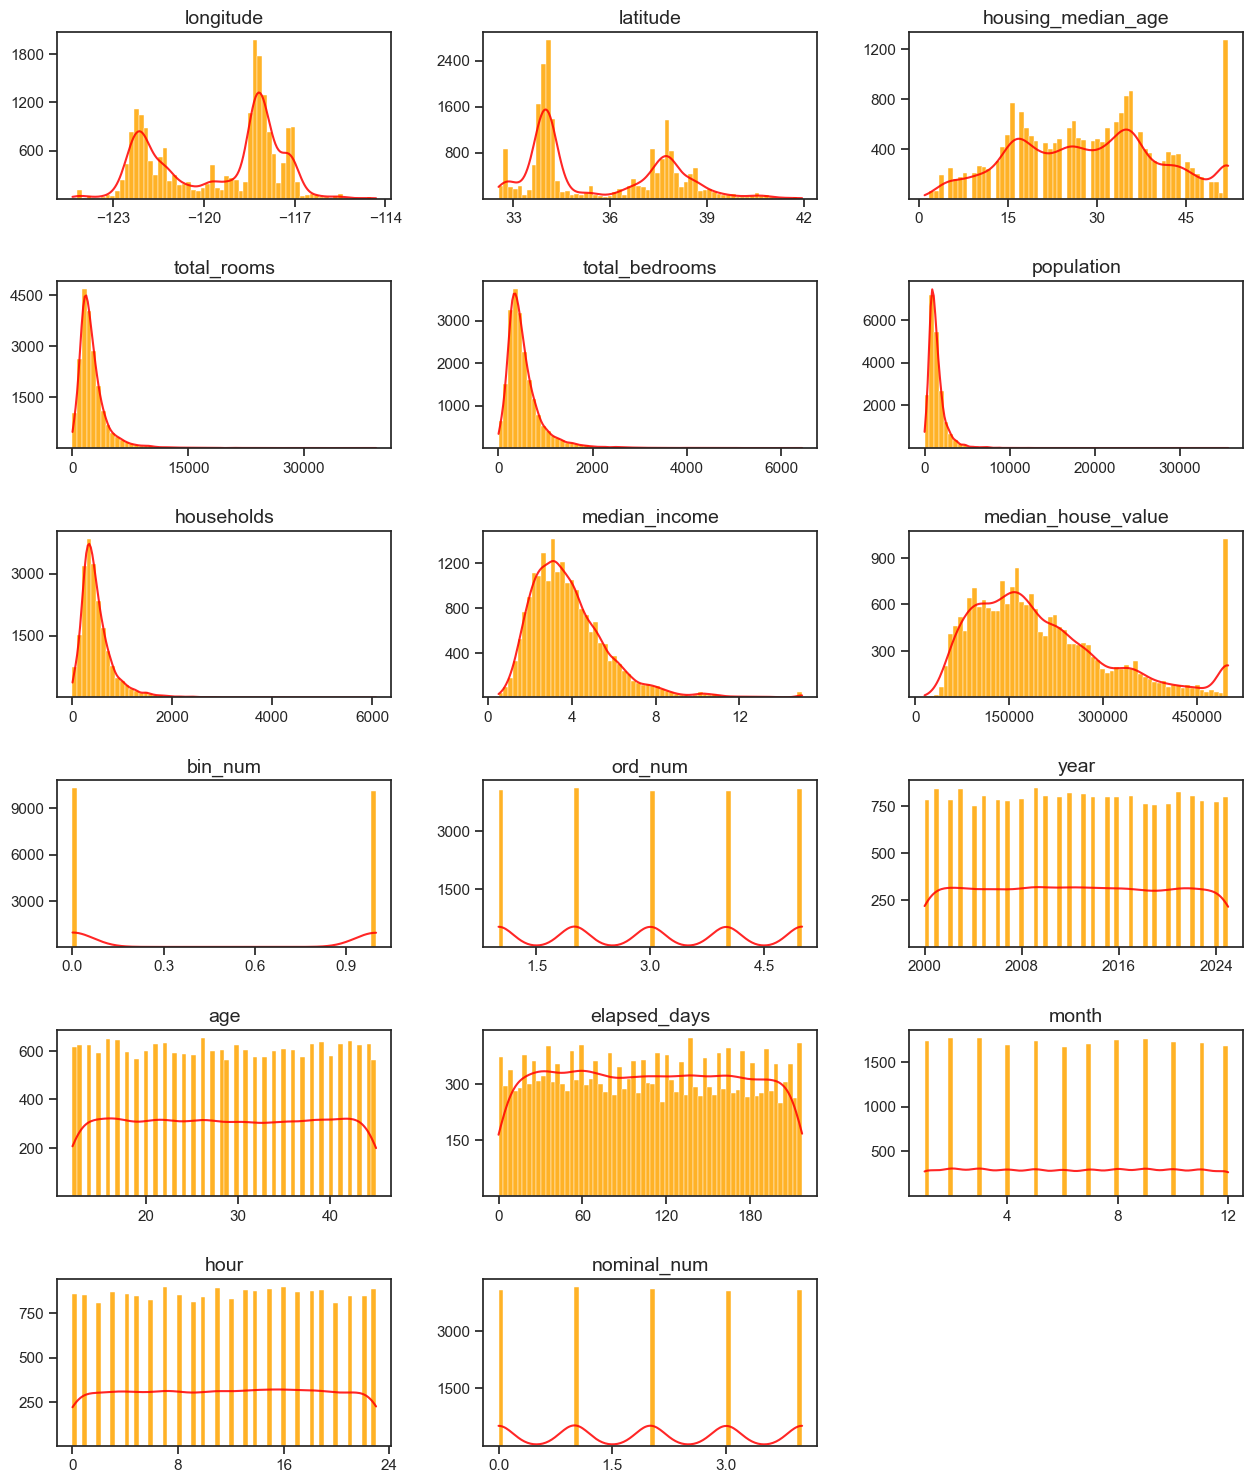

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import MaxNLocator

df = data

# Select numeric columns, excluding 'row'
Ss = [col for col in df.select_dtypes(include='number').columns if col != "row"]

# Grid layout
n_cols = 3
n_rows = math.ceil(len(Ss) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=( 13, 15.3))
axes = axes.flatten()

for i, col in enumerate(Ss):
    col_df = df[col].dropna()

    # Plot histogram with KDE on same axis
    sns.histplot(col_df, bins=64, color='orange', kde=True, alpha=0.85, ax=axes[i])

    # Recolor KDE line to deeppink
    for line in axes[i].lines:
        line.set_color('red')
        line.set_alpha(0.85)

    # Clean up labels and ticks
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))

# Remove unused axes
for j in range(len(Ss), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)
fig.savefig("Hist_Kde_Dirty_Outliers.png", dpi=300, bbox_inches='tight')  # png pdf svg

plt.show()

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> Handling False Zeros in Scalars

In [14]:
# help
display( pd.DataFrame({ 'min':data[Ss].min(), 'max':data[Ss].max() }))

,min,max
longitude,-124.3500,-114.3100
latitude,32.5400,41.9500
housing_median_age,1.0000,52.0000
total_rooms,2.0000,39320.0000
total_bedrooms,1.0000,6445.0000
population,0.0000,35682.0000
households,0.0000,6082.0000
median_income,0.4999,15.0001
median_house_value,14999.0000,500001.0000
bin_num,0.0000,1.0000


In [15]:
# help
print( Ss )

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'bin_num', 'ord_num', 'year', 'age', 'elapsed_days', 'month', 'hour', 'nominal_num']


In [16]:
# input
Ss_with_false_zeros = [ 'population', 'households' ]
Thresholds          = [ 1e-16, 1e-16  ]

#####   

In [17]:
# auto
# Finding False Zeros
def find_false_zeros( df, ft, Threshold ):
    L = df[ ft ].copy().dropna().tolist() 
    False_Zeros = []
    for i in df.index:
        if df.loc[i,ft]<Threshold: False_Zeros.append(i)
    return False_Zeros

A = pd.DataFrame( columns = data.columns )
for i in range( len(Ss_with_false_zeros) ):
    sclr        = Ss_with_false_zeros[i] 
    Threshold   = Thresholds[i]
    False_Zeros = find_false_zeros( data, sclr, Threshold )
    for i in False_Zeros:
        A.loc[i,sclr] = data.loc[i,sclr]
print( '\nfound  ' + str(A.shape[0]) + '  rows including False Zeros' )



# Saving False Zeros
def color_non_null(val):
    if pd.isnull(val):  return 'background-color:   white; color: white;'
    else:               return 'background-color: #FFE4E1; color: black;'
    
A.index.name = 'row'
A[Ss_with_false_zeros].\
    style.map(color_non_null).\
    format(precision=0).\
    to_excel('False_Zeros.xlsx', engine='openpyxl')



found  11  rows including False Zeros


#####   

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:deeppink;"> converting False Zeros to None

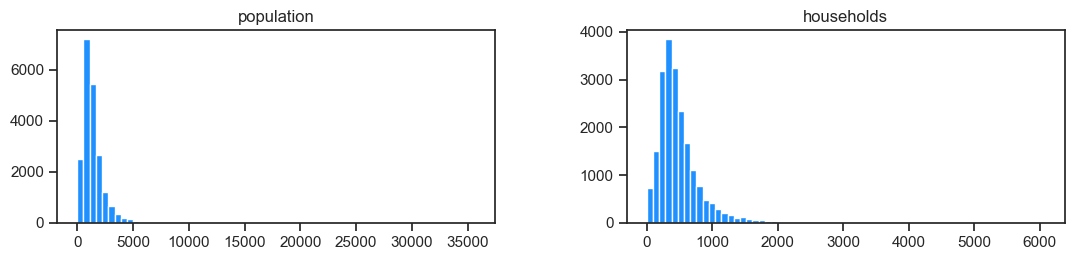

In [18]:
# input 
Convert = False

# auto --- converting False Zeros to None
if Convert:
    n_ft = len( Ss_with_false_zeros )

    for n in range( n_ft ):
        ft = Ss_with_false_zeros[ n ]
        th = Thresholds[ n ]
    
        D   = data[ft].copy()
        n_D = len( data[ft] ) 
    
        for i in data.index:
            if D[i] < th:
                D[i] = None
    
        data[ft] = D.copy().astype(float)
    

# Hist
if len( Ss_with_false_zeros ) > 0:
    h = len( Ss_with_false_zeros )
    h = (h-1)//3 + 1
    h = h * 2.5
    data[ Ss_with_false_zeros ].hist(bins=64,grid=False,color='dodgerblue',figsize=(13,h)); plt.show()

#####   

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Saving & Loading

In [19]:
pickle.dump( data,  open('Data_Imputed_Into_None','wb') )  # save
data = pickle.load( open('Data_Imputed_Into_None','rb') )  # load

#####   

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Checking conversion into None

In [20]:
# Final Checking 
data.head(150).fillna('*******')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,bin_num,bin_cat,ord_num,ord_cat,datetime,year,age,elapsed_days,month,hour,nominal_num,nominal_cat
row,,,,,,,,,,,,,,,,,,,,,,
2,-122.23,37.88,41.0,880,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,1.0,Yes,5.0,Very High,2025-12-17 22:00:00,2001.0,27.0,141.0,10.0,21.0,0.0,Violet
3,-122.22,37.86,21.0,7099,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,1.0,Yes,4.0,High,2025-07-18 07:00:00,2020.0,35.0,5.0,3.0,18.0,2.0,Blue
4,-122.24,37.85,52.0,1467,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,1.0,Yes,1.0,Very Low,2022-08-24 21:00:00,2001.0,43.0,78.0,2.0,6.0,3.0,Green
5,-122.25,37.85,52.0,1274,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,0.0,No,3.0,Medium,2022-08-02 14:00:00,2000.0,24.0,37.0,9.0,9.0,3.0,Green
6,-122.26,37.84,42.0,2555,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,1.0,Yes,4.0,High,2024-04-22 14:00:00,2015.0,26.0,184.0,12.0,23.0,1.0,Pink
7,-122.25,37.85,52.0,1627,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,1.0,Yes,5.0,Very High,2023-05-09 05:00:00,*******,*******,*******,1.0,1.0,0.0,Violet
8,-122.25,37.85,52.0,919,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,1.0,Yes,2.0,Low,2023-02-22 00:00:00,*******,*******,*******,9.0,22.0,4.0,Red
9,-122.25,37.84,52.0,2535,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,1.0,Yes,2.0,Low,2017-03-06 01:00:00,2012.0,21.0,157.0,*******,*******,3.0,Green
10,-122.25,37.84,52.0,3104,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,0.0,No,2.0,Low,2024-06-23 06:00:00,2024.0,25.0,159.0,*******,*******,2.0,Blue


#####   

<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Total Time

In [21]:
# (auto)
t_termin = time.time()
Minutes  = (t_termin - t_init) // 60
Seconds  = (t_termin - t_init) %  60
print( 'Total Time:  '+str(int(Minutes))+' min  '+str(int(np.round(Seconds,0)))+' sec')

Total Time:  0 min  16 sec


#####   

#####   

<span style="font-family:MV Boli; font-weight:Bold; font-size:2.3em; color:#00b3e5;"> END

#####   

#####   

#####   

#####   
<span style="font-family:MV Boli; font-weight:Bold; font-size:1.8em; color:#00b3e5;"> Quick View on Univariate Outliers

In [22]:
# auto
Report = pd.DataFrame(index=Ss)

# Basic stats
Report['min'] = data[Ss].min()
Report['max'] = data[Ss].max()
Report['P25'] = data[Ss].quantile(0.25)
Report['P50'] = data[Ss].median()
Report['P75'] = data[Ss].quantile(0.75)
Report['IQR'] = Report['P75'] - Report['P25']

# IQR-based bounds
Report['MIN'] = Report['P25'] - 1.5 * Report['IQR']
Report['MAX'] = Report['P75'] + 1.5 * Report['IQR'] 

# Winsorizing
New           = pd.DataFrame()
for ft in Ss:  
    New[ft]   = np.clip( data[ft].values, Report.loc[ft,'MIN'], Report.loc[ft,'MAX'] )
Mean = New[Ss].mean()
Std  = New[Ss].std()

# Z-score outliers
z_values_df   = (data[Ss] - Mean) / Std
Report['Z_Outliers'] = [ (np.abs(z_values_df[ft]) > 3).sum() for ft in Ss ]

Report = Report.round(2)
display(Report)

,min,max,P25,P50,P75,IQR,MIN,MAX,Z_Outliers
longitude,-124.35,-114.31,-121.80,-118.50,-118.01,3.79,-127.48,-112.33,0
latitude,32.54,41.95,33.93,34.26,37.72,3.79,28.24,43.40,0
housing_median_age,1.00,52.00,18.00,29.00,37.00,19.00,-10.50,65.50,0
total_rooms,2.00,39320.00,1447.00,2127.00,3147.00,1700.00,-1103.00,5697.00,862
total_bedrooms,1.00,6445.00,296.00,435.00,647.00,351.00,-230.50,1173.50,847
population,0.00,35682.00,786.00,1166.00,1724.25,938.25,-621.38,3131.62,784
households,0.00,6082.00,279.00,409.00,605.00,326.00,-210.00,1094.00,804
median_income,0.50,15.00,2.56,3.53,4.74,2.18,-0.71,8.02,444
median_house_value,14999.00,500001.00,119800.00,179800.00,264900.00,145100.00,-97850.00,482550.00,0
bin_num,0.00,1.00,0.00,0.00,1.00,1.00,-1.50,2.50,0


#####   